In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found

tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Save references to each table
measurement_table=Base.classes.measurement
station_table=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

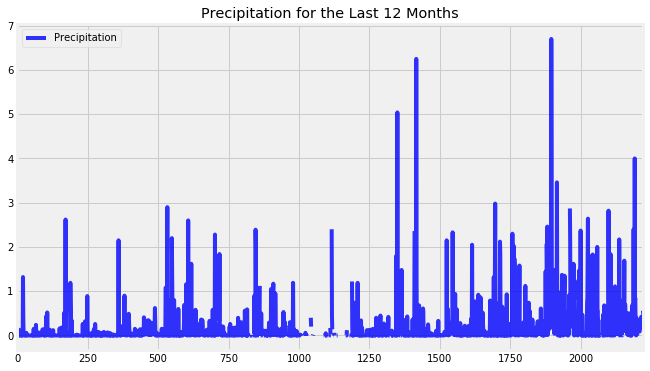

In [174]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precipitation12months = session.query(measurement_table.prcp).filter(measurement_table.date == "2010-01-01")
precipitation12months

# Calculate the date 1 year ago from the last data point in the database
##find the last date
last_date = session.query(measurement_table.date).order_by(measurement_table.date.desc()).first()
last_date

##find date greater than one year ago (2016-08-23)
twelve_months_date=session.query(measurement_table.date).\
filter(measurement_table.date >= '2016-08-23')
twelve_months_date

#date_1year_ago= session.query(measurement_table.date).order_by(measurement_table.date).all()
#date_1year_agoa

# Perform a query to retrieve the data and precipitation scores
precipitation_12months = session.query(measurement_table.date,measurement_table.prcp).filter(measurement_table.date > '2016-08-23').all()
precipitation_12months 

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation_12months,columns=['Date', 'Precipitation'])

precipitation_df

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()
precipitation_df

# Use Pandas Plotting with Matplotlib to plot the data

precipitation_df.plot(title="Precipitation for the Last 12 Months", color='blue', alpha=0.8, figsize=(10,6))

plt.savefig("Images_Output/Precipitation.png")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_summary=precipitation_df.describe()
precipitation_summary

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(station_table).count()

9

In [124]:
# What are the most active stations? (i.e. what stations have the most rows)?


# List the stations and the counts in descending order.
most_active_session=session.query(measurement_table.station, func.count(measurement_table.station)).\
group_by(measurement_table.station).order_by(func.count(measurement_table.station).desc()).all()
most_active_session

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [126]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowest_highest_avg_temp=session.query(func.min(measurement_table.tobs),func.max(measurement_table.tobs),func.avg(measurement_table.tobs)).\
filter(measurement_table.station=="USC00519281").all()   
lowest_highest_avg_temp


[(54.0, 85.0, 71.66378066378067)]

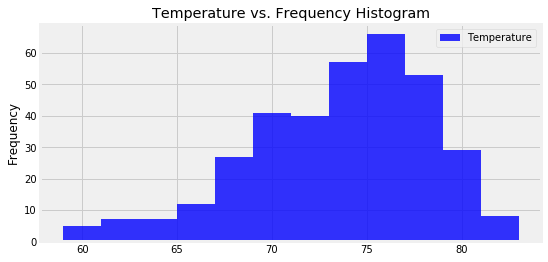

In [173]:
# Choose the station with the highest number of temperature observations.


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp=session.query(measurement_table.tobs).filter(measurement_table.station=="USC00519281").\
filter(measurement_table.date >= '2016-08-23').all()
temp

#create dataframe
temp_df=pd.DataFrame(temp,columns=['Temperature'])

#Create Histogram

temp_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram",color='blue', alpha=0.8, figsize=(8,4))

plt.savefig("Images_Output/TemperaturevsFrequency.png")

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement_table.tobs), func.avg(measurement_table.tobs), func.max(measurement_table.tobs)).\
        filter(measurement_table.date >= start_date).filter(measurement_table.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [30]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

start_date = dt.date(2016, 2, 3) - dt.timedelta(days=365)
end_date = dt.date(2016, 2, 14) - dt.timedelta(days=365)

temp_data=calc_temps(start_date, end_date)
temp_data

[(58.0, 70.08333333333333, 79.0)]

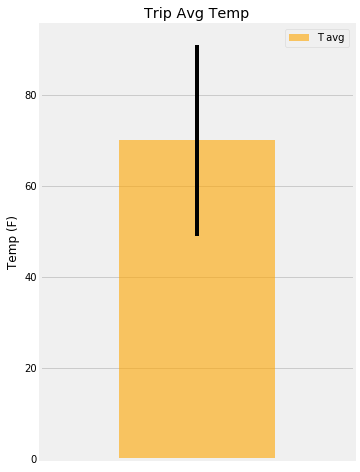

In [175]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp_data_df=pd.DataFrame(temp_data,columns=["T min","T avg","T max"])
temp_data_df.plot.bar(title="Trip Avg Temp",color='orange',alpha=0.6, figsize=(5,8),
                      y="T avg",yerr=(temp_data_df["T max"]-temp_data_df["T min"]))
                      
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")


plt.savefig("Images_Output/TripAvgTemp.png")

In [177]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(measurement_table.station,func.sum(measurement_table.prcp),\
                               station_table.name,station_table.latitude,\
                                station_table.longitude,station_table.elevation).\
                                filter(measurement_table.date >='2015-02-13').\
                                filter(measurement_table.date <='2015-02-20').\
                                group_by(station_table.name).order_by(func.sum(measurement_table.prcp).desc()).all()
total_rainfall

[('USC00519397',
  5.579999999999999,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  5.579999999999999,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00519397',
  5.579999999999999,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519397',
  5.579999999999999,
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('USC00519397',
  5.579999999999999,
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9),
 ('USC00519397',
  5.579999999999999,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519397',
  5.579999999999999,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  5.579999999999999,
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('USC00519397',
  5.579999999999999,
  'HONOLULU OBSERVATORY 702.2, HI US',
  21.3152,
  -157.9992,
  0.9)]

In [138]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement_table.tobs), func.avg(measurement_table.tobs), func.max(measurement_table.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement_table.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [154]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip()

start_date = "2016-02-03" 
end_date = "2016-02-14"


# Use the start and end date to create a range of dates

trip_date=pd.date_range(start_date,end_date)
trip_date

# Stip off the year and save a list of %m-%d strings

trip_date_one=trip_date.strftime("%m-%d")
trip_date_one

trip_list=[]

# Loop through the list of %m-%d strings and calculate the normals for each date
for x in trip_date_one:
    trip_list.append(*daily_normals(x))
trip_list

[(58.0, 67.79661016949153, 77.0),
 (61.0, 68.14035087719299, 76.0),
 (59.0, 69.6842105263158, 80.0),
 (58.0, 70.38983050847457, 77.0),
 (60.0, 69.0, 77.0),
 (56.0, 66.75438596491227, 74.0),
 (57.0, 67.58928571428571, 75.0),
 (56.0, 68.41666666666667, 76.0),
 (61.0, 69.25, 79.0),
 (60.0, 69.15789473684211, 78.0),
 (58.0, 70.36206896551724, 80.0),
 (62.0, 70.89473684210526, 79.0)]

In [160]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_list_df=pd.DataFrame(trip_list,columns=["temp min","temp average","temp max"])
trip_list_df['date']=trip_date
trip_list_df.set_index(['date'],inplace=True)
trip_list_df

,temp min,temp average,temp max
date,,,
2016-02-03,58.0,67.796610,77.0
2016-02-04,61.0,68.140351,76.0
2016-02-05,59.0,69.684211,80.0
2016-02-06,58.0,70.389831,77.0
2016-02-07,60.0,69.000000,77.0
2016-02-08,56.0,66.754386,74.0
2016-02-09,57.0,67.589286,75.0
2016-02-10,56.0,68.416667,76.0
2016-02-11,61.0,69.250000,79.0


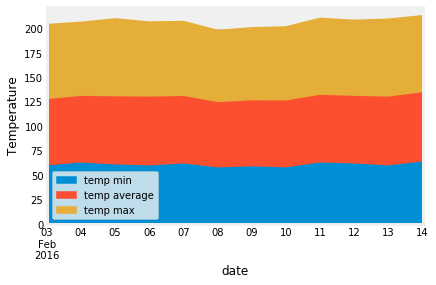

In [171]:
# Plot the daily normals as an area plot with `stacked=False`
trip_list_df.plot(kind="area")

plt.ylabel("Temperature")
plt.savefig("Images_Output/AreaPlot.png")